# Finding the Optimal Discrimination Threshold in Classification Problems

The script for our implementation of the plot is in the file `interactive_discrimination_threshold.py` (which itself calls `app.py`).

In [1]:
import pandas as pd
from pandas import CategoricalDtype
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from yellowbrick.classifier.threshold import discrimination_threshold
import warnings

from interactive_discrimination_threshold import InteractiveDiscriminationThreshold

## Dataset and Model

Here we build a pipeline with a random forest classifier and train it on the "telco-customer-churn" dataset from [OpenML](https://www.openml.org/d/42178).

In [11]:
X, y = fetch_openml(name='telco-customer-churn', return_X_y=True, as_frame=True)

Before feeding the data to the pipeline, we clean and transform it to avoid any undesirable effects in later stages. In particular - since the pipeline will be trained and tested multiple times on various subsamples of our dataset - we want to eliminate the cases when a categorical predictor in the test set receives a value not present in the training set. One way to deal with it is to try the stratified random split, but our dataset contains too many non-numeric columns. Another option is to explicitly transform non-numeric columns into pandas' CategoricalDtype with predefined ordered values, so that whenever some value for some column does not exist in the training set, receiving such a value in the test would not lead to incorrectly assigned labels or any other logical error. The function *transform_data()* below does exactly that.  However, we should note that to implement the second option, we have to know in advance all possible values for the categorical columns. 

In [12]:
def transform_data(df: pd.DataFrame) -> pd.DataFrame:
    "Transform non-numeric columns into categorical type and clean data."
    df = df.copy()
    df['gender'] = (
        df['gender'].astype(CategoricalDtype(categories=['Male', 'Female']))
    )
    for col in ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']:
        df[col] = df[col].astype(CategoricalDtype(categories=['No', 'Yes']))
    for col in ['OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport',
                'StreamingTV', 'StreamingMovies']:
        cat_values = ['No', 'Yes', 'No internet service']
        df[col] = df[col].astype(CategoricalDtype(categories=cat_values))
    df['InternetService'] = (
        df['InternetService']
        .astype(CategoricalDtype(categories=['Fiber optic', 'DSL', 'No']))
    )
    df['MultipleLines'] = (
        df['MultipleLines']
        .astype(CategoricalDtype(categories=['No', 'Yes', 'No phone service']))
    )
    contract_categories = ['Month-to-month', 'Two year', 'One year']
    df['Contract'] = (
        X['Contract']
        .astype(CategoricalDtype(categories=contract_categories))
    )
    paymethod_categories = ['Electronic check', 'Mailed check',
                            'Bank transfer (automatic)',
                            'Credit card (automatic)']
    df['PaymentMethod'] = (
        df['PaymentMethod']
        .astype(CategoricalDtype(categories=paymethod_categories))
    )
    df.loc[df['TotalCharges'] == ' ', 'TotalCharges'] = '0'
    df['TotalCharges'] = df['TotalCharges'].astype(float)
    return df

X = transform_data(X)

Because we transformed the data, the OrdinalEncoder() function in the pipeline below knows in advance all the values that categorical variables could possibly take. 

In [14]:
encode_cat = ColumnTransformer(
  [('cat', OrdinalEncoder(), make_column_selector(dtype_include='category'))],
  remainder='passthrough'
)

model = Pipeline(steps=[
    ('encode_cat', encode_cat),
    ('rfc', RandomForestClassifier(n_estimators=50, oob_score=True))
])

## Existing Implementation

Perhaps, there are several existing implementations of DS plot, but the most common is the one from [Yellowbrick](https://www.scikit-yb.org/en/latest/api/classifier/threshold.html) package. 

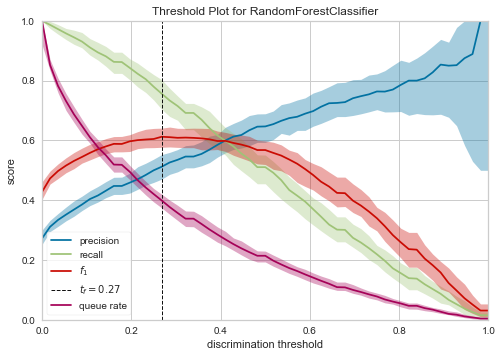

In [15]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    discrimination_threshold(model, X, (y == 'Yes').astype(int))

## Tailor-Made Interactive Plot

The Yellowbrick's plot has two drawbacks:

1) It is static, which makes it difficult to observe the values for precision, recall and other measures for any given threshold;

2) In Yellowbrick's plot doesn't allow to perform cost-benefit analysis and the optimal threshold there is defined as the one where F1 score reaches its maximum point.
    
In contrast, our Plotly Dash implementation of this plot is designed so that:

1) We can see the value of each measure by hovering mouse pointer to the area near that value.

2) If we know (i) the screening capacity, i.e. what share of observations with positive predicted values you are capable to screen and see if they are true positives or not; (ii) cost of screening one observation; and (iii) estimated revenue from identifying false negatives (or loss from missing false positives), then we can redefine the optimal threshold as the solution to revenue maximization (or loss minimization) problem given the screen capacity as the constraint.

In [6]:
disc_threshold = InteractiveDiscriminationThreshold(
    model, X, y, label_dict={0: 'No', 1: 'Yes'})
disc_threshold.prepare_data(store_data=True)

100%|███████████████████████████████████████████| 35/35 [00:11<00:00,  2.96it/s]


If we want to observe the plot within this notebook, we call plot with the parameter app_mode='inline' and if we want to see the plot in a separate window, we call it with app_mode='external'. For all other parameters, please see the docstring for the class or function.

In [7]:
disc_threshold.plot(app_mode='external')

Dash app running on http://127.0.0.1:8050/
